In [411]:
import sys

import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import scale
import torch 


from pytorch_forecasting import NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data

sys.path.append("..")
from neuralprophet import df_utils
import numpy as np

In [131]:
"""
N-Beats model for timeseries forecasting without covariates.
"""
from typing import Dict, List

import matplotlib.pyplot as plt
import torch
from torch import nn

from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import MAE, MAPE, MASE, RMSE, SMAPE, MultiHorizonMetric
from pytorch_forecasting.models.base_model import BaseModel
from pytorch_forecasting.models.nbeats.sub_modules import NBEATSGenericBlock, NBEATSSeasonalBlock, NBEATSTrendBlock


class NBeats(BaseModel):
    def __init__(
        self,
        stack_types: List[str] = ["trend", "seasonality"],
        num_blocks=[3, 3],
        num_block_layers=[3, 3],
        widths=[32, 512],
        sharing: List[int] = [True, True],
        expansion_coefficient_lengths: List[int] = [3, 7],
        prediction_length: int = 1,
        context_length: int = 1,
        dropout: float = 0.1,
        learning_rate: float = 1e-2,
        log_interval: int = -1,
        log_gradient_flow: bool = False,
        log_val_interval: int = None,
        weight_decay: float = 1e-3,
        loss: MultiHorizonMetric = None,
        reduce_on_plateau_patience: int = 1000,
        backcast_loss_ratio: float = 0.0,
        logging_metrics: nn.ModuleList = None,
        **kwargs,
    ):
        """
        Initialize NBeats Model - use its :py:meth:`~from_dataset` method if possible.
        Based on the article
        `N-BEATS: Neural basis expansion analysis for interpretable time series
        forecasting <http://arxiv.org/abs/1905.10437>`_. The network has (if used as ensemble) outperformed all
        other methods
        including ensembles of traditional statical methods in the M4 competition. The M4 competition is arguably
        the most
        important benchmark for univariate time series forecasting.
        Args:
            stack_types: One of the following values: “generic”, “seasonality" or “trend". A list of strings
                of length 1 or ‘num_stacks’. Default and recommended value
                for generic mode: [“generic”] Recommended value for interpretable mode: [“trend”,”seasonality”]
            num_blocks: The number of blocks per stack. A list of ints of length 1 or ‘num_stacks’.
                Default and recommended value for generic mode: [1] Recommended value for interpretable mode: [3]
            num_block_layers: Number of fully connected layers with ReLu activation per block. A list of ints of length
                1 or ‘num_stacks’.
                Default and recommended value for generic mode: [4] Recommended value for interpretable mode: [4]
            width: Widths of the fully connected layers with ReLu activation in the blocks.
                A list of ints of length 1 or ‘num_stacks’. Default and recommended value for generic mode: [512]
                Recommended value for interpretable mode: [256, 2048]
            sharing: Whether the weights are shared with the other blocks per stack.
                A list of ints of length 1 or ‘num_stacks’. Default and recommended value for generic mode: [False]
                Recommended value for interpretable mode: [True]
            expansion_coefficient_length: If the type is “G” (generic), then the length of the expansion
                coefficient.
                If type is “T” (trend), then it corresponds to the degree of the polynomial. If the type is “S”
                (seasonal) then this is the minimum period allowed, e.g. 2 for changes every timestep.
                A list of ints of length 1 or ‘num_stacks’. Default value for generic mode: [32] Recommended value for
                interpretable mode: [3]
            prediction_length: Length of the prediction. Also known as 'horizon'.
            context_length: Number of time units that condition the predictions. Also known as 'lookback period'.
                Should be between 1-10 times the prediction length.
            backcast_loss_ratio: weight of backcast in comparison to forecast when calculating the loss.
                A weight of 1.0 means that forecast and backcast loss is weighted the same (regardless of backcast and
                forecast lengths). Defaults to 0.0, i.e. no weight.
            loss: loss to optimize. Defaults to MASE().
            log_gradient_flow: if to log gradient flow, this takes time and should be only done to diagnose training
                failures
            reduce_on_plateau_patience (int): patience after which learning rate is reduced by a factor of 10
            logging_metrics (nn.ModuleList[MultiHorizonMetric]): list of metrics that are logged during training.
                Defaults to nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE(), MASE()])
            **kwargs: additional arguments to :py:class:`~BaseModel`.
        """
        if logging_metrics is None:
            logging_metrics = nn.ModuleList([SMAPE(), MAE(), RMSE(), MAPE(), MASE()])
        if loss is None:
            loss = MASE()
        self.save_hyperparameters()
        super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)

        self.forecaster = None
        # setup stacks
        self.net_blocks = nn.ModuleList()
        for stack_id, stack_type in enumerate(stack_types):
            for _ in range(num_blocks[stack_id]):
                if stack_type == "generic":
                    net_block = NBEATSGenericBlock(
                        units=self.hparams.widths[stack_id],
                        thetas_dim=self.hparams.expansion_coefficient_lengths[stack_id],
                        num_block_layers=self.hparams.num_block_layers[stack_id],
                        backcast_length=context_length,
                        forecast_length=prediction_length,
                        dropout=self.hparams.dropout,
                    )
                elif stack_type == "seasonality":
                    net_block = NBEATSSeasonalBlock(
                        units=self.hparams.widths[stack_id],
                        num_block_layers=self.hparams.num_block_layers[stack_id],
                        backcast_length=context_length,
                        forecast_length=prediction_length,
                        min_period=self.hparams.expansion_coefficient_lengths[stack_id],
                        dropout=self.hparams.dropout,
                    )
                elif stack_type == "trend":
                    net_block = NBEATSTrendBlock(
                        units=self.hparams.widths[stack_id],
                        thetas_dim=self.hparams.expansion_coefficient_lengths[stack_id],
                        num_block_layers=self.hparams.num_block_layers[stack_id],
                        backcast_length=context_length,
                        forecast_length=prediction_length,
                        dropout=self.hparams.dropout,
                    )
                else:
                    raise ValueError(f"Unknown stack type {stack_type}")

                self.net_blocks.append(net_block)

    def forward(self, x: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
        """
        Pass forward of network.
        Args:
            x (Dict[str, torch.Tensor]): input from dataloader generated from
                :py:class:`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`.
        Returns:
            Dict[str, torch.Tensor]: output of model
        """
        target = x["encoder_cont"][..., 0]

        timesteps = self.hparams.context_length + self.hparams.prediction_length
        generic_forecast = [torch.zeros((target.size(0), timesteps), dtype=torch.float32, device=self.device)]
        trend_forecast = [torch.zeros((target.size(0), timesteps), dtype=torch.float32, device=self.device)]
        seasonal_forecast = [torch.zeros((target.size(0), timesteps), dtype=torch.float32, device=self.device)]
        forecast = torch.zeros(
            (target.size(0), self.hparams.prediction_length), dtype=torch.float32, device=self.device
        )

        backcast = target  # initialize backcast
        for i, block in enumerate(self.net_blocks):
            # evaluate block
            backcast_block, forecast_block = block(backcast)

            # add for interpretation
            full = torch.cat([backcast_block.detach(), forecast_block.detach()], dim=1)
            if isinstance(block, NBEATSTrendBlock):
                trend_forecast.append(full)
            elif isinstance(block, NBEATSSeasonalBlock):
                seasonal_forecast.append(full)
            else:
                generic_forecast.append(full)

            # update backcast and forecast
            backcast = (
                backcast - backcast_block
            )  # do not use backcast -= backcast_block as this signifies an inline operation
            forecast = forecast + forecast_block

        return dict(
            prediction=forecast,
            target_scale=x["target_scale"],
            backcast=target - backcast,
            trend=torch.stack(trend_forecast, dim=0).sum(0),
            seasonality=torch.stack(seasonal_forecast, dim=0).sum(0),
            generic=torch.stack(generic_forecast, dim=0).sum(0),
        )

    @classmethod
    def from_dataset(cls, dataset: TimeSeriesDataSet, **kwargs):
        """
        Convenience function to create network from :py:class`~pytorch_forecasting.data.timeseries.TimeSeriesDataSet`.
        Args:
            dataset (TimeSeriesDataSet): dataset where sole predictor is the target.
            **kwargs: additional arguments to be passed to ``__init__`` method.
        Returns:
            NBeats
        """
        new_kwargs = {"prediction_length": dataset.max_prediction_length, "context_length": dataset.max_encoder_length}
        new_kwargs.update(kwargs)

        # validate arguments
        assert isinstance(dataset.target, str), "only one target is allowed (passed as string to dataset)"
        assert not isinstance(
            dataset.target_normalizer, NaNLabelEncoder
        ), "only regression tasks are supported - target must not be categorical"
        assert (
            dataset.min_encoder_length == dataset.max_encoder_length
        ), "only fixed encoder length is allowed, but min_encoder_length != max_encoder_length"

        assert (
            dataset.max_prediction_length == dataset.min_prediction_length
        ), "only fixed prediction length is allowed, but max_prediction_length != min_prediction_length"

        assert dataset.randomize_length is None, "length has to be fixed, but randomize_length is not None"
        assert not dataset.add_relative_time_idx, "add_relative_time_idx has to be False"

        assert (
            len(dataset.flat_categoricals) == 0
            and len(dataset.reals) == 1
            and len(dataset.time_varying_unknown_reals) == 1
            and dataset.time_varying_unknown_reals[0] == dataset.target
        ), "The only variable as input should be the target which is part of time_varying_unknown_reals"

        # initialize class
        return super().from_dataset(dataset, **new_kwargs)

    def step(self, x, y, batch_idx) -> Dict[str, torch.Tensor]:
        """
        Take training / validation step.
        """
        log, out = super().step(x, y, batch_idx=batch_idx)

        if self.hparams.backcast_loss_ratio > 0:  # add loss from backcast
            backcast = self.transform_output(dict(prediction=out["backcast"], target_scale=out["target_scale"]))
            backcast_weight = (
                self.hparams.backcast_loss_ratio * self.hparams.prediction_length / self.hparams.context_length
            )
            backcast_weight = backcast_weight / (backcast_weight + 1)  # normalize
            forecast_weight = 1 - backcast_weight
            if isinstance(self.loss, MASE):
                backcast_loss = self.loss(backcast, x["encoder_target"], x["decoder_target"]) * backcast_weight
            else:
                backcast_loss = self.loss(backcast, x["encoder_target"]) * backcast_weight
            label = ["val", "train"][self.training]
            self.log(f"{label}_backcast_loss", backcast_loss, on_epoch=True, on_step=self.training)
            self.log(f"{label}_forecast_loss", log["loss"], on_epoch=True, on_step=self.training)
            log["loss"] = log["loss"] * forecast_weight + backcast_loss

        self._log_interpretation(x, out, batch_idx=batch_idx)
        return log, out
    
    def set_forecaster(self, self_forecaster):
        self.forecaster = self_forecaster
    
    def training_step(self, batch, batch_idx):
        """
        Train on batch.
        """
        x, y = batch
        log, y_hat = self.step(x, y, batch_idx)
        y_hat = y_hat['prediction'][0]
        y = y[0]
        
        # log loss
        self.log("train_loss", log["loss"], on_step=True, on_epoch=True, prog_bar=True)
        if type(self.forecaster) != type(None):
            self.forecaster.metrics.update(predicted=y_hat.detach(), target=y.detach(), values={"Loss": log["loss"]})
        return log

    def training_epoch_end(self, outputs):
        self.epoch_end(outputs)
        if type(self.forecaster) != type(None):
            epoch_metrics = self.forecaster.metrics.compute(save=True)
            self.forecaster.metrics.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        log, y_hat = self.step(x, y, batch_idx)  # log loss
        y_hat = y_hat['prediction'][0]
        y = y[0]

        self.log("val_loss", log["loss"], on_step=False, on_epoch=True, prog_bar=True)
        if type(self.forecaster) != type(None):
            self.forecaster.val_metrics.update(predicted=y_hat.detach(), target=y.detach())
        return log

    def validation_epoch_end(self, outputs):
        self.epoch_end(outputs)
        if type(self.forecaster) != type(None):
            val_epoch_metrics = self.forecaster.val_metrics.compute(save=True)
            self.forecaster.val_metrics.reset()

    def _log_interpretation(self, x, out, batch_idx):
        """
        Log interpretation of network predictions in tensorboard.
        """
        label = ["val", "train"][self.training]
        if self.log_interval > 0 and batch_idx % self.log_interval == 0:
            fig = self.plot_interpretation(x, out, idx=0)
            name = f"{label.capitalize()} interpretation of item 0 in "
            if self.training:
                name += f"step {self.global_step}"
            else:
                name += f"batch {batch_idx}"
            self.logger.experiment.add_figure(name, fig, global_step=self.global_step)

    def plot_interpretation(
        self,
        x: Dict[str, torch.Tensor],
        output: Dict[str, torch.Tensor],
        idx: int,
        ax=None,
        plot_seasonality_and_generic_on_secondary_axis: bool = False,
    ) -> plt.Figure:
        """
        Plot interpretation.
        Plot two pannels: prediction and backcast vs actuals and
        decomposition of prediction into trend, seasonality and generic forecast.
        Args:
            x (Dict[str, torch.Tensor]): network input
            output (Dict[str, torch.Tensor]): network output
            idx (int): index of sample for which to plot the interpretation.
            ax (List[matplotlib axes], optional): list of two matplotlib axes onto which to plot the interpretation.
                Defaults to None.
            plot_seasonality_and_generic_on_secondary_axis (bool, optional): if to plot seasonality and
                generic forecast on secondary axis in second panel. Defaults to False.
        Returns:
            plt.Figure: matplotlib figure
        """
        if ax is None:
            fig, ax = plt.subplots(2, 1, figsize=(6, 8))
        else:
            fig = ax[0].get_figure()

        time = torch.arange(-self.hparams.context_length, self.hparams.prediction_length)

        def to_prediction(y):
            return self.transform_output(dict(prediction=y[[idx]], target_scale=x["target_scale"][[idx]]))[0]

        # plot target vs prediction
        ax[0].plot(time, torch.cat([x["encoder_target"][idx], x["decoder_target"][idx]]).detach().cpu(), label="target")
        ax[0].plot(
            time,
            torch.cat(
                [
                    to_prediction(output["backcast"].detach()),
                    output["prediction"][idx].detach(),
                ],
                dim=0,
            ).cpu(),
            label="prediction",
        )
        ax[0].set_xlabel("Time")

        # plot blocks
        prop_cycle = iter(plt.rcParams["axes.prop_cycle"])
        next(prop_cycle)  # prediction
        next(prop_cycle)  # observations
        if plot_seasonality_and_generic_on_secondary_axis:
            ax2 = ax[1].twinx()
            ax2.set_ylabel("Seasonality / Generic")
        else:
            ax2 = ax[1]
        for title in ["trend", "seasonality", "generic"]:
            if title not in self.hparams.stack_types:
                continue
            if title == "trend":
                ax[1].plot(
                    time,
                    to_prediction(output[title]).detach().cpu(),
                    label=title.capitalize(),
                    c=next(prop_cycle)["color"],
                )
            else:
                ax2.plot(
                    time,
                    to_prediction(output[title]).detach().cpu(),
                    label=title.capitalize(),
                    c=next(prop_cycle)["color"],
                )
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Decomposition")

        fig.legend()
        return fig

In [132]:
def _handle_missing_data(df, freq, predicting=False):
        """Checks, auto-imputes and normalizes new data

        Args:
            df (pd.DataFrame): raw data with columns 'ds' and 'y'
            freq (str): data frequency
            predicting (bool): when no lags, allow NA values in 'y' of forecast series or 'y' to miss completely

        Returns:
            pre-processed df
        """

        impute_limit_linear = 5
        impute_rolling = 20


        df, missing_dates = df_utils.add_missing_dates_nan(df, freq=freq)

        # impute missing values
        data_columns = []
        data_columns.append("y")

        for column in data_columns:
            sum_na = sum(df[column].isnull())
            if sum_na > 0:
                df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(
                        df[column],
                        limit_linear=impute_limit_linear,
                        rolling=impute_rolling,
                        )
                if remaining_na > 0:
                    raise ValueError(
                        "More than {} consecutive missing values encountered in column {}. "
                        "{} NA remain. Please preprocess data manually.".format(
                            2 * impute_limit_linear + impute_rolling, column, remaining_na
                        )
                    )
        return df

In [133]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/"
else:
    data_location = "../"

df = pd.read_csv(data_location + "example_data/yosemite_temps.csv")
df.head(3)
freq = '5min'

df = df.iloc[:1000]

In [134]:
df = df_utils.check_dataframe(df)
df = _handle_missing_data(df, freq)
df = df[['ds', 'y']]
df['time_idx'] = range(df.shape[0])
df['series'] = 0

In [135]:
df.shape[0]

1000

In [136]:
def set_auto_batch_epoch(
    n_data: int,
    min_batch: int = 16,
    max_batch: int = 256,
    min_epoch: int = 40,
    max_epoch: int = 400,
):
    assert n_data >= 1
    log_data = np.log10(n_data)
    batch_size = 2 ** int(2 + log_data)
    batch_size = min(max_batch, max(min_batch, batch_size))
    batch_size = min(n_data, batch_size)
    return batch_size

In [137]:
batch_size = set_auto_batch_epoch(df.shape[0])

In [138]:
batch_size

32

In [139]:
valid_p = 0.2
max_encoder_length = 150

epochs = 100
num_gpus = 0
patience_early_stopping = 10
early_stop = True
weight_decay=1e-2
learning_rate=3e-2
auto_lr_find=True
max_prediction_length = int(valid_p*df.shape[0])
training_cutoff = df.shape[0] - int(valid_p*df.shape[0])

context_length = max_encoder_length
prediction_length = max_prediction_length

In [140]:

training_cutoff

800

In [141]:
prediction_length

200

In [142]:
 df.iloc[:training_cutoff]

,ds,y,time_idx,series
0,2017-05-01 00:00:00,27.8,0,0
1,2017-05-01 00:05:00,27.0,1,0
2,2017-05-01 00:10:00,26.8,2,0
3,2017-05-01 00:15:00,26.5,3,0
4,2017-05-01 00:20:00,25.6,4,0
...,...,...,...,...
795,2017-05-03 18:15:00,33.3,795,0
796,2017-05-03 18:20:00,33.6,796,0
797,2017-05-03 18:25:00,34.1,797,0
798,2017-05-03 18:30:00,35.1,798,0


In [143]:
training = TimeSeriesDataSet(
    df.iloc[:training_cutoff],
    time_idx="time_idx",
    target="y",
    categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=["series"],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    min_prediction_length=prediction_length,
    time_varying_unknown_reals=["y"],
    randomize_length=None,
    add_relative_time_idx=False,
    add_target_scales=False,
)

validation = TimeSeriesDataSet.from_dataset(training,
                                            df,
                                            min_prediction_idx=training_cutoff)

train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=6)

In [144]:
len(train_dataloader)

14

In [145]:
len(val_dataloader)

1

In [146]:
if early_stop:
    early_stop_callback = EarlyStopping(monitor="val_loss",
                                        min_delta=1e-4,
                                        patience=patience_early_stopping,
                                        verbose=False,
                                        mode="min")
    callbacks=[early_stop_callback]
    
trainer = pl.Trainer(
    max_epochs=epochs,
    gpus=num_gpus,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=callbacks,
    checkpoint_callback=False,
    logger=False,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [147]:
net = NBeats.from_dataset(training,
                          learning_rate=learning_rate,
                          log_gradient_flow=False,
                          weight_decay=weight_decay, 
#                           prediction_length = 10
)
print(f"Number of parameters in network: {net.size()/1e3:.1f}k")

Number of parameters in network: 2136.2k


In [148]:
len(train_dataloader)

14

In [149]:
if auto_lr_find:
    res = trainer.tuner.lr_find(net,
                                train_dataloader=train_dataloader,
#                                 val_dataloaders=val_dataloader,
                                min_lr=1e-5,
                                max_lr=1e2
    )

    net.hparams.learning_rate = res.suggestion()


WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.1 M 
-----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.545     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early due to diverging loss.
Restored states from the checkpoint file at /Users/polina/fds/neural_prophet/project_notebooks/lr_find_temp_model.ckpt


In [150]:
res.suggestion()

0.00457088189614875

In [151]:
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)


  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.1 M 
-----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.545     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 13it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [277]:
df

,ds,y,time_idx,series
0,2017-05-01 00:00:00,27.8,0,0
1,2017-05-01 00:05:00,27.0,1,0
2,2017-05-01 00:10:00,26.8,2,0
3,2017-05-01 00:15:00,26.5,3,0
4,2017-05-01 00:20:00,25.6,4,0
...,...,...,...,...
995,2017-05-04 10:55:00,8.3,995,0
996,2017-05-04 11:00:00,8.2,996,0
997,2017-05-04 11:05:00,8.2,997,0
998,2017-05-04 11:10:00,8.2,998,0


In [278]:
max_encoder_length
n_historic_predictions = 20

In [330]:
periods = 10

encoder_data = df[lambda x: x.time_idx > x.time_idx.max() - (max_encoder_length+n_historic_predictions)]
last_data = df[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(ds=lambda x: x.ds + pd.offsets.MonthBegin(i)) for i in range(1, periods + 1)],
    ignore_index=True,
)
decoder_data['time_idx'] = range(decoder_data['time_idx'].iloc[0]+1, decoder_data['time_idx'].iloc[0] + periods+1)
decoder_data['ds'] = pd.date_range(start = encoder_data['ds'].iloc[-1], periods = periods+1, freq = freq)[1:]
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

testing = TimeSeriesDataSet(
    new_prediction_data,
    time_idx="time_idx",
    target="y",
    categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
    group_ids=["series"],
    min_encoder_length=context_length,
    max_encoder_length=context_length,
    max_prediction_length=periods + n_historic_predictions,
    min_prediction_length=periods + n_historic_predictions,
    time_varying_unknown_reals=["y"],
    randomize_length=None,
    add_relative_time_idx=False,
    add_target_scales=False,
)

new_raw_predictions, new_x = net.predict(testing, mode="raw", return_x=True)
y_predicted = net.to_prediction(new_raw_predictions).detach().cpu()[0, : new_x["decoder_lengths"][0]]
y_predicted = y_predicted.detach().numpy()

new_prediction_data.loc[len(new_prediction_data)-periods:, 'y'] = None
new_prediction_data['yhat1'] = None
new_prediction_data.loc[len(new_prediction_data)-len(y_predicted):, 'yhat1'] = y_predicted
cols = ["ds", "y", "yhat1"]  # cols to keep from df
df_forecast = pd.concat((new_prediction_data[cols],), axis=1)
df_forecast["residual1"] = df_forecast['yhat1'] - df_forecast["y"]

In [331]:
periods

10

In [334]:
new_prediction_data

,ds,y,time_idx,series,yhat1
0,2017-05-03 21:10:00,41.5,830,0,None
1,2017-05-03 21:15:00,41.1,831,0,None
2,2017-05-03 21:20:00,41.9,832,0,None
3,2017-05-03 21:25:00,41.4,833,0,None
4,2017-05-03 21:30:00,40.9,834,0,None
...,...,...,...,...,...
175,2017-05-04 11:45:00,NaN,1005,0,8.85682
176,2017-05-04 11:50:00,NaN,1006,0,8.773195
177,2017-05-04 11:55:00,NaN,1007,0,8.578517
178,2017-05-04 12:00:00,NaN,1008,0,8.361511


In [337]:
df_forecast

,ds,y,yhat1,residual1
0,2017-05-03 21:10:00,41.5,None,None
1,2017-05-03 21:15:00,41.1,None,None
2,2017-05-03 21:20:00,41.9,None,None
3,2017-05-03 21:25:00,41.4,None,None
4,2017-05-03 21:30:00,40.9,None,None
...,...,...,...,...
175,2017-05-04 11:45:00,NaN,8.85682,NaN
176,2017-05-04 11:50:00,NaN,8.773195,NaN
177,2017-05-04 11:55:00,NaN,8.578517,NaN
178,2017-05-04 12:00:00,NaN,8.361511,NaN


In [288]:
y_predicted.detach().numpy()#.shape

array([9.843916 , 9.034057 , 8.82039  , 8.930555 , 9.041139 , 8.985822 ,
       8.807304 , 8.661922 , 8.673831 , 8.8457775, 9.074268 , 9.237728 ,
       9.282884 , 9.248034 , 9.215849 , 9.239009 , 9.297136 , 9.31481  ,
       9.223829 , 9.021822 , 8.783209 , 8.614448 , 8.584396 , 8.678139 ,
       8.805233 , 8.85682  , 8.773195 , 8.578517 , 8.361511 , 8.217318 ],
      dtype=float32)

In [283]:

# y_hat.detach().cpu()[idx, : x["decoder_lengths"][idx]]

In [284]:
new_raw_predictions['prediction'].shape

torch.Size([1, 200])

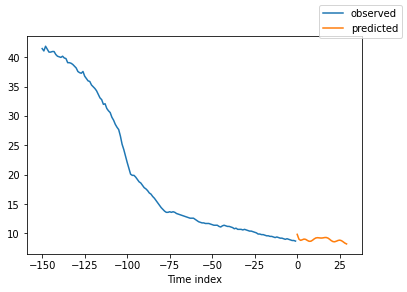

In [285]:
net.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False);


In [234]:
new_raw_predictions

{'prediction': tensor([[ 8.5359,  8.0949,  7.9416,  7.9277,  7.8672,  7.6731,  7.3971,  7.1686,
           7.0916,  7.1776,  7.3514,  7.5135,  7.6069,  7.6384,  7.6480,  7.6562,
           7.6362,  7.5350,  7.3264,  7.0545,  6.8289,  6.7659,  6.9129,  7.2056,
           7.4933,  7.6222,  7.5262,  7.2698,  7.0133,  6.9193,  7.0574,  7.3652,
           7.6865,  7.8655,  7.8363,  7.6579,  7.4764,  7.4433,  7.6374,  8.0357,
           8.5396,  9.0334,  9.4374,  9.7305,  9.9414, 10.1257, 10.3477, 10.6690,
          11.1377, 11.7699, 12.5297, 13.3258, 14.0423, 14.5972, 14.9986, 15.3583,
          15.8412, 16.5714, 17.5472, 18.6237, 19.5842, 20.2651, 20.6593, 20.9318,
          21.3287, 22.0318, 23.0463, 24.1927, 25.2128, 25.9252, 26.3335, 26.6217,
          27.0385, 27.7445, 28.7166, 29.7688, 30.6705, 31.2880, 31.6586, 31.9589,
          32.3907, 33.0625, 33.9379, 34.8748, 35.7213, 36.4005, 36.9328, 37.3924,
          37.8352, 38.2556, 38.5984, 38.8134, 38.9090, 38.9638, 39.0888, 39.3649,
  

In [231]:
new_raw_predictions

{'prediction': tensor([[ 8.5359,  8.0949,  7.9416,  7.9277,  7.8672,  7.6731,  7.3971,  7.1686,
           7.0916,  7.1776,  7.3514,  7.5135,  7.6069,  7.6384,  7.6480,  7.6562,
           7.6362,  7.5350,  7.3264,  7.0545,  6.8289,  6.7659,  6.9129,  7.2056,
           7.4933,  7.6222,  7.5262,  7.2698,  7.0133,  6.9193,  7.0574,  7.3652,
           7.6865,  7.8655,  7.8363,  7.6579,  7.4764,  7.4433,  7.6374,  8.0357,
           8.5396,  9.0334,  9.4374,  9.7305,  9.9414, 10.1257, 10.3477, 10.6690,
          11.1377, 11.7699, 12.5297, 13.3258, 14.0423, 14.5972, 14.9986, 15.3583,
          15.8412, 16.5714, 17.5472, 18.6237, 19.5842, 20.2651, 20.6593, 20.9318,
          21.3287, 22.0318, 23.0463, 24.1927, 25.2128, 25.9252, 26.3335, 26.6217,
          27.0385, 27.7445, 28.7166, 29.7688, 30.6705, 31.2880, 31.6586, 31.9589,
          32.3907, 33.0625, 33.9379, 34.8748, 35.7213, 36.4005, 36.9328, 37.3924,
          37.8352, 38.2556, 38.5984, 38.8134, 38.9090, 38.9638, 39.0888, 39.3649,
  

In [180]:
new_prediction_data.iloc[-12:]

,ds,y,time_idx,series,date
148,2017-05-04 11:10:00,8.2,998,0,NaT
149,2017-05-04 11:15:00,8.1,999,0,NaT
150,2017-05-04 11:15:00,8.1,999,0,2017-06-01 11:15:00
151,2017-05-04 11:15:00,8.1,1000,0,2017-06-02 11:15:00
152,2017-05-04 11:15:00,8.1,1001,0,2017-06-03 11:15:00
153,2017-05-04 11:15:00,8.1,1002,0,2017-06-04 11:15:00
154,2017-05-04 11:15:00,8.1,1003,0,2017-06-05 11:15:00
155,2017-05-04 11:15:00,8.1,1004,0,2017-06-06 11:15:00
156,2017-05-04 11:15:00,8.1,1005,0,2017-06-07 11:15:00
157,2017-05-04 11:15:00,8.1,1006,0,2017-06-08 11:15:00


In [651]:
import torch 
from pytorch_forecasting import Baseline
from pytorch_forecasting.metrics import SMAPE

# calculate baseline absolute error
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
SMAPE()(baseline_predictions, actuals)

tensor(0.6554)

In [652]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = net.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(4.8949)

In [653]:
predictions

tensor([[40.6727, 42.0756, 42.6413, 42.7618, 42.8205, 43.0814, 43.6171, 44.2963,
         44.8596, 45.0697, 44.8695, 44.4480, 44.1544, 44.2923, 44.9168, 45.7734,
         46.4353, 46.5650, 46.1364, 45.4653, 45.0222, 45.1433, 45.8295, 46.7633,
         47.5321, 47.9010, 47.9526, 47.9988, 48.3321, 48.9890, 49.6944, 50.0274,
         49.7017, 48.7752, 47.6508, 46.8660, 46.7993, 47.4696, 48.5358, 49.4835,
         49.8786, 49.5512, 48.6294, 47.4378, 46.3364, 45.5847, 45.2766, 45.3451,
         45.6135, 45.8682, 45.9356, 45.7450, 45.3532, 44.9111, 44.5768, 44.4165,
         44.3527, 44.2012, 43.7820, 43.0389, 42.0879, 41.1546, 40.4381, 39.9889,
         39.6848, 39.3207, 38.7513, 37.9844, 37.1620, 36.4422, 35.8751, 35.3625,
         34.7383, 33.9083, 32.9439, 32.0549, 31.4498, 31.1819, 31.0939, 30.9066,
         30.3998, 29.5604, 28.5945, 27.7905, 27.3226, 27.1286, 26.9434, 26.4697,
         25.5695, 24.3522, 23.1048, 22.1129, 21.4940, 21.1463, 20.8395, 20.3764,
         19.7176, 18.9905, 1

In [655]:
predictions.detach().numpy().shape

(1, 200)

In [656]:
SMAPE()(predictions, actuals)

tensor(0.2297)

In [266]:
raw_predictions, x = net.predict(val_dataloader, mode="raw", return_x=True)


In [267]:
raw_predictions

{'prediction': tensor([[36.2222, 36.6456, 36.7787, 36.9945, 37.4558, 38.0939, 38.7226, 39.1895,
          39.4653, 39.6313, 39.7970, 40.0192, 40.2795, 40.5218, 40.7110, 40.8638,
          41.0312, 41.2512, 41.5133, 41.7608, 41.9295, 41.9925, 41.9796, 41.9595,
          41.9991, 42.1281, 42.3295, 42.5547, 42.7505, 42.8771, 42.9140, 42.8574,
          42.7178, 42.5219, 42.3112, 42.1308, 42.0094, 41.9414, 41.8860, 41.7881,
          41.6103, 41.3566, 41.0701, 40.8063, 40.5982, 40.4385, 40.2891, 40.1116,
          39.8957, 39.6639, 39.4498, 39.2652, 39.0817, 38.8415, 38.4919, 38.0218,
          37.4737, 36.9232, 36.4388, 36.0457, 35.7173, 35.3963, 35.0302, 34.5976,
          34.1101, 33.5933, 33.0621, 32.5097, 31.9172, 31.2742, 30.5956, 29.9189,
          29.2841, 28.7073, 28.1670, 27.6118, 26.9877, 26.2685, 25.4730, 24.6585,
          23.8937, 23.2261, 22.6596, 22.1561, 21.6580, 21.1206, 20.5376, 19.9450,
          19.4022, 18.9591, 18.6275, 18.3727, 18.1300, 17.8376, 17.4693, 17.0468,
  

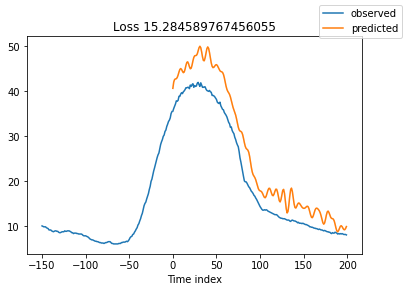

In [658]:
net.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

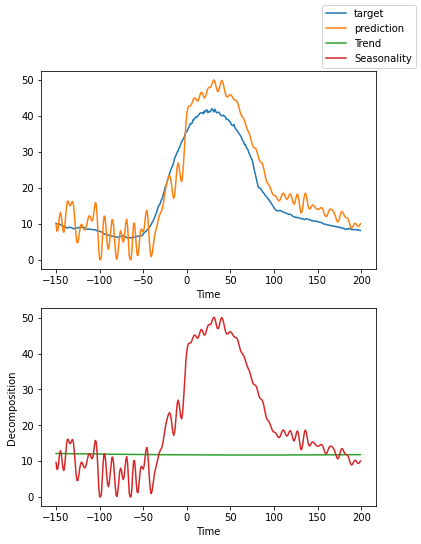

In [659]:
net.plot_interpretation(x, raw_predictions, idx=0);


In [402]:
from neuralprophet import metrics
from neuralprophet.plot_forecast import plot

class NBeatsNP:
    def __init__(
        self,
        max_encoder_length = 150,
        batch_size = None,
        epochs = 100,
        num_gpus = 0,
        patience_early_stopping = 10,
        early_stop = True,
        weight_decay=1e-2,
        learning_rate=3e-2,
        auto_lr_find=True,
        num_workers=3,
        loss_func = 'Huber'
    ):
        
        self.batch_size = batch_size
        
        self.max_encoder_length = max_encoder_length

        self.epochs = epochs
        self.num_gpus = num_gpus
        self.patience_early_stopping = patience_early_stopping
        self.early_stop = early_stop
        self.weight_decay = weight_decay
        self.learning_rate=learning_rate
        self.auto_lr_find=auto_lr_find
        self.num_workers = num_workers
        
        self.loss_func = loss_func
        self.fitted = False
        
        if type(self.loss_func) == str:
            if self.loss_func.lower() in ["huber", "smoothl1", "smoothl1loss"]:
                self.loss_func = torch.nn.SmoothL1Loss()
            elif self.loss_func.lower() in ["mae", "l1", "l1loss"]:
                self.loss_func = torch.nn.L1Loss()
            elif self.loss_func.lower() in ["mse", "mseloss", "l2", "l2loss"]:
                self.loss_func = torch.nn.MSELoss()
            else:
                raise NotImplementedError("Loss function {} name not defined".format(self.loss_func))
        elif callable(self.loss_func):
            pass
        elif hasattr(torch.nn.modules.loss, self.loss_func.__class__.__name__):
            pass
        else:
            raise NotImplementedError("Loss function {} not found".format(self.loss_func))
        
        
        
        
        self.metrics = metrics.MetricsCollection(
            metrics=[
                metrics.LossMetric(self.loss_func),
                metrics.MAE(),
                metrics.MSE(),
            ],
            value_metrics=[
                # metrics.ValueMetric("Loss"),
            ],
        )
        
        self.val_metrics = metrics.MetricsCollection([m.new() for m in self.metrics.batch_metrics])
        
    
    def _init_model(self, training, train_dataloader):
        model = NBeats.from_dataset(training,
                          learning_rate=self.learning_rate,
                          log_gradient_flow=False,
                          weight_decay=self.weight_decay,
                                    )
        if self.auto_lr_find:
            res = self.trainer.tuner.lr_find(model,
                                        train_dataloader=train_dataloader,
                                        min_lr=1e-5,
                                        max_lr=1e2)

            model.hparams.learning_rate = res.suggestion()
            self.learning_rate = res.suggestion()
            

        return model
        
    def set_auto_batch_epoch(self,
                                n_data: int,
                                min_batch: int = 16,
                                max_batch: int = 256,
                                min_epoch: int = 40,
                                max_epoch: int = 400,
                            ):
        assert n_data >= 1
        log_data = np.log10(n_data)
        if self.batch_size is None:
            self.batch_size = 2 ** int(2 + log_data)
            self.batch_size = min(max_batch, max(min_batch, self.batch_size))
            self.batch_size = min(n_data, self.batch_size)

    def _handle_missing_data(sefl, df, freq, predicting=False):
        """Checks, auto-imputes and normalizes new data

        Args:
            df (pd.DataFrame): raw data with columns 'ds' and 'y'
            freq (str): data frequency
            predicting (bool): when no lags, allow NA values in 'y' of forecast series or 'y' to miss completely

        Returns:
            pre-processed df
        """

        impute_limit_linear = 5
        impute_rolling = 20


        df, missing_dates = df_utils.add_missing_dates_nan(df, freq=freq)

        # impute missing values
        data_columns = []
        data_columns.append("y")

        for column in data_columns:
            sum_na = sum(df[column].isnull())
            if sum_na > 0:
                df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(
                        df[column],
                        limit_linear=impute_limit_linear,
                        rolling=impute_rolling,
                        )
                if remaining_na > 0:
                    raise ValueError(
                        "More than {} consecutive missing values encountered in column {}. "
                        "{} NA remain. Please preprocess data manually.".format(
                            2 * impute_limit_linear + impute_rolling, column, remaining_na
                        )
                    )
        return df
    
    def _create_dataset(self, df, freq, valid_p):
        df = df_utils.check_dataframe(df)
        df = self._handle_missing_data(df, freq)
        df = df[['ds', 'y']]
        df['time_idx'] = range(df.shape[0])
        df['series'] = 0
        self.n_data = df.shape[0]
        self.set_auto_batch_epoch(self.n_data)
        
        max_prediction_length = int(valid_p*df.shape[0])
        training_cutoff = df.shape[0] - int(valid_p*df.shape[0])

        self.context_length = self.max_encoder_length
        self.prediction_length = max_prediction_length
        
        training = TimeSeriesDataSet(
            df.iloc[:training_cutoff],
            time_idx="time_idx",
            target="y",
            categorical_encoders={"series": NaNLabelEncoder().fit(df.series)},
            group_ids=["series"],
            min_encoder_length=self.context_length,
            max_encoder_length=self.context_length,
            max_prediction_length=self.prediction_length,
            min_prediction_length=self.prediction_length,
            time_varying_unknown_reals=["y"],
            randomize_length=None,
            add_relative_time_idx=False,
            add_target_scales=False,
        )

        validation = TimeSeriesDataSet.from_dataset(training,
                                                    df,
                                                    min_prediction_idx=training_cutoff)

        train_dataloader = training.to_dataloader(train=True,
                                                  batch_size=self.batch_size,
                                                  num_workers=self.num_workers)
        val_dataloader = validation.to_dataloader(train=False,
                                                  batch_size=self.batch_size,
                                                  num_workers=self.num_workers)
        
        return training, train_dataloader, val_dataloader
    
    def _train(self, training, train_dataloader, val_dataloader, hyperparameter_optim = False):
        callbacks = []
        if self.early_stop:
            early_stop_callback = EarlyStopping(monitor="val_loss",
                                                min_delta=1e-4,
                                                patience=self.patience_early_stopping,
                                                verbose=False,
                                                mode="min")
            callbacks=[early_stop_callback]

        self.trainer = pl.Trainer(
            max_epochs=self.epochs,
            gpus=self.num_gpus,
            weights_summary="top",
            gradient_clip_val=0.1,
            callbacks=callbacks,
            checkpoint_callback=False,
            logger=False,
        )
        
        self.model = self._init_model(training, train_dataloader)
        self.model.set_forecaster(self)
        
        self.metrics.reset()
        self.val_metrics.reset()
        
        if hyperparameter_optim:
            return self.model
        else:
        
            self.trainer.fit(self.model,
                        train_dataloader=train_dataloader,
                        val_dataloaders=val_dataloader,
                       )
            self.fitted = True

            metrics_df = self.metrics.get_stored_as_df()
            metrics_df_val = self.val_metrics.get_stored_as_df()
            for col in metrics_df_val.columns:
                metrics_df["{}_val".format(col)] = metrics_df_val[col]

            return metrics_df
        
        
    
    def fit(self, df, freq, valid_p=0.2):
        
        training, train_dataloader, val_dataloader = self._create_dataset(df, freq, valid_p)
        metrics_df = self._train(training, train_dataloader, val_dataloader)
        return metrics_df

        
    def _hyperparameter_optimization(self, df, freq, valid_p=0.2):
        training, train_dataloader, val_dataloader = self._create_dataset(df, freq, valid_p)
        model = self._train(training, train_dataloader, val_dataloader, hyperparameter_optim = True)
        

        
    def make_future_dataframe(self, df, periods=0, n_historic_predictions=0):
        
        self.periods = periods
        self.n_historic_predictions = n_historic_predictions
        
        df = df.copy(deep=True)
        
        df = df_utils.check_dataframe(df)
        df = self._handle_missing_data(df, freq)
        df = df[['ds', 'y']]
        df['time_idx'] = range(df.shape[0])
        df['series'] = 0
        self.n_data = df.shape[0]

        encoder_data = df[lambda x: x.time_idx>x.time_idx.max()-(self.max_encoder_length+n_historic_predictions)]
        last_data = df[lambda x: x.time_idx == x.time_idx.max()]
        decoder_data = pd.concat(
            [last_data.assign(ds=lambda x: x.ds + pd.offsets.MonthBegin(i)) for i in range(1, periods + 1)],
            ignore_index=True,
        )
        decoder_data['time_idx'] = range(decoder_data['time_idx'].iloc[0]+1,
                                         decoder_data['time_idx'].iloc[0] + periods+1)
        decoder_data['ds'] = pd.date_range(start = encoder_data['ds'].iloc[-1],
                                           periods = periods+1, freq = freq)[1:]
        future_dataframe = pd.concat([encoder_data, decoder_data], ignore_index=True)

        return future_dataframe

    
    def predict(self, future_dataframe):

        if self.fitted is False:
            log.warning("Model has not been fitted. Predictions will be random.")
            
        future_dataframe = future_dataframe.copy(deep = True)
        testing = TimeSeriesDataSet(
            future_dataframe,
            time_idx="time_idx",
            target="y",
            categorical_encoders={"series": NaNLabelEncoder().fit(future_dataframe.series)},
            group_ids=["series"],
            min_encoder_length=self.context_length,
            max_encoder_length=self.context_length,
            max_prediction_length=self.periods + self.n_historic_predictions,
            min_prediction_length=self.periods + self.n_historic_predictions,
            time_varying_unknown_reals=["y"],
            randomize_length=None,
            add_relative_time_idx=False,
            add_target_scales=False,
        )

        new_raw_predictions, new_x = net.predict(testing, mode="raw", return_x=True)
        y_predicted = net.to_prediction(new_raw_predictions).detach().cpu()[0, : new_x["decoder_lengths"][0]]
        y_predicted = y_predicted.detach().numpy()

        future_dataframe.loc[len(future_dataframe)-periods:, 'y'] = None
        future_dataframe['yhat1'] = None
        future_dataframe.loc[len(future_dataframe)-len(y_predicted):, 'yhat1'] = y_predicted
        cols = ["ds", "y", "yhat1"]  # cols to keep from df
        df_forecast = pd.concat((future_dataframe[cols],), axis=1)
        df_forecast["residual1"] = df_forecast['yhat1'] - df_forecast["y"]
 
        return df_forecast

    def plot(self, fcst, ax=None, xlabel="ds", ylabel="y", figsize=(10, 6)):
        """Plot the NeuralProphet forecast, including history.

        Args:
            fcst (pd.DataFrame): output of self.predict.
            ax (matplotlib axes): Optional, matplotlib axes on which to plot.
            xlabel (string): label name on X-axis
            ylabel (string): label name on Y-axis
            figsize (tuple):   width, height in inches. default: (10, 6)

        Returns:
            A matplotlib figure.
        """

        return plot(
            fcst=fcst,
            ax=ax,
            xlabel=xlabel,
            ylabel=ylabel,
            figsize=figsize,
        )

In [404]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    data_location = "https://raw.githubusercontent.com/ourownstory/neural_prophet/master/"
else:
    data_location = "../"

df = pd.read_csv(data_location + "example_data/yosemite_temps.csv")
df.head(3)
freq = '5min'

df = df.iloc[:1000]

In [405]:
m = NBeatsNP(
        max_encoder_length = 150,
        batch_size = None,
        epochs = 10,
        num_gpus = 0,
        patience_early_stopping = 10,
        early_stop = True,
        weight_decay=1e-2,
        learning_rate=3e-2,
        auto_lr_find=False,
        num_workers=3,
    )

In [406]:
m.fit(df, freq = freq)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 2.1 M 
-----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.545     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([1, 200])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



Training: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/torch/nn/modules/loss.py:907: UserWarning: Using a target size (torch.Size([32, 200])) that is different to the input size (torch.Size([200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)



Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

,SmoothL1Loss,MAE,MSE,SmoothL1Loss_val,MAE_val,MSE_val
0,12.423286,12.913329,277.783230,11.123768,11.619485,207.094193
1,12.223427,12.713893,264.529321,4.512948,4.997940,38.354992
2,11.946546,12.436333,254.188162,2.423177,2.883211,12.968214
3,10.781327,11.266518,222.564298,1.163027,1.602576,3.647255
4,12.998940,13.486062,299.794981,1.209535,1.648436,4.069310
5,12.888589,13.374100,306.023182,1.058989,1.512501,3.159473
6,12.831464,13.316180,295.477453,0.843607,1.271642,2.382060
7,13.312466,13.799982,311.814766,1.240191,1.686920,4.136969
8,11.305130,11.788811,245.594000,2.511095,2.959953,14.750189
9,12.088112,12.575372,267.653557,2.561236,2.996240,15.540662


In [407]:
future = m.make_future_dataframe(df, periods=10, n_historic_predictions=10)

In [408]:
future

,ds,y,time_idx,series
0,2017-05-03 22:00:00,40.1,840,0
1,2017-05-03 22:05:00,40.0,841,0
2,2017-05-03 22:10:00,40.2,842,0
3,2017-05-03 22:15:00,39.9,843,0
4,2017-05-03 22:20:00,39.8,844,0
...,...,...,...,...
165,2017-05-04 11:45:00,8.1,1005,0
166,2017-05-04 11:50:00,8.1,1006,0
167,2017-05-04 11:55:00,8.1,1007,0
168,2017-05-04 12:00:00,8.1,1008,0


In [409]:
forecast = m.predict(future)

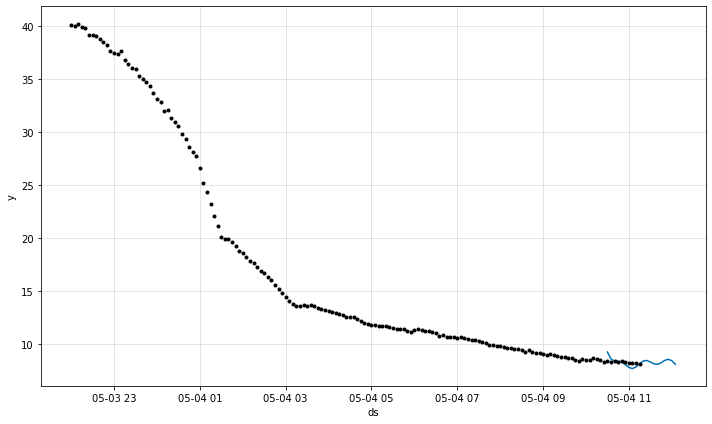

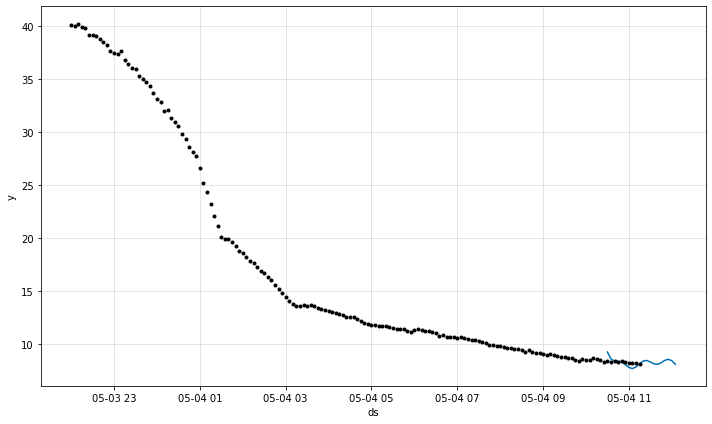

In [410]:
m.plot(forecast)

In [380]:
from neuralprophet import NeuralProphet

In [381]:
m = NeuralProphet()

In [382]:
m.fit(df, freq = '5min')

INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 121


  0%|          | 0/250 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.15E-02, min: 1.57E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 3.76E-01

  0%|          | 0/121 [00:00<?, ?it/s]GPU available: False, used: False
TPU available: False, using: 0 TPU cores
WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: you defined a validation_step but have no val_dataloader. Skipping validation loop
  warnings.warn(*args, **kwargs)


  | Name          | Type          | Params
------------------------------------------------
0 | season_params | ParameterDict | 12    
1 | loss_func     | SmoothL1Loss  | 0     
------------------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Users/polina/.conda/envs/neural_prophet/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



Training: 0it [00:00, ?it/s]

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.467641,30.902222,1419.065908,0.0
1,0.269495,21.570727,751.780219,0.0
2,0.133790,13.927976,347.507545,0.0
3,0.052139,8.782296,133.646340,0.0
4,0.020133,5.581442,51.607048,0.0
...,...,...,...,...
116,0.000083,0.352486,0.212354,0.0
117,0.000096,0.382060,0.245109,0.0
118,0.000101,0.387175,0.257990,0.0
119,0.000084,0.359383,0.216293,0.0


In [383]:
future = m.make_future_dataframe(df, periods=10, n_historic_predictions=10)

In [384]:
future

,ds,y,t,y_scaled
0,2017-05-04 10:30:00,8.4,0.990991,0.145251
1,2017-05-04 10:35:00,8.3,0.991992,0.142458
2,2017-05-04 10:40:00,8.4,0.992993,0.145251
3,2017-05-04 10:45:00,8.3,0.993994,0.142458
4,2017-05-04 10:50:00,8.4,0.994995,0.145251
5,2017-05-04 10:55:00,8.3,0.995996,0.142458
6,2017-05-04 11:00:00,8.2,0.996997,0.139665
7,2017-05-04 11:05:00,8.2,0.997998,0.139665
8,2017-05-04 11:10:00,8.2,0.998999,0.139665
9,2017-05-04 11:15:00,8.1,1.000000,0.136872


In [385]:
m.predict(future)

,ds,y,yhat1,residual1,trend,season_daily
0,2017-05-04 10:30:00,8.4,8.493174,0.093174,20.260674,-11.767501
1,2017-05-04 10:35:00,8.3,8.484806,0.184806,20.264177,-11.779370
2,2017-05-04 10:40:00,8.4,8.479083,0.079083,20.267681,-11.788597
3,2017-05-04 10:45:00,8.3,8.475773,0.175773,20.271183,-11.795410
4,2017-05-04 10:50:00,8.4,8.474587,0.074587,20.274687,-11.800098
5,2017-05-04 10:55:00,8.3,8.475202,0.175202,20.278191,-11.802987
6,2017-05-04 11:00:00,8.2,8.477253,0.277253,20.281693,-11.804440
7,2017-05-04 11:05:00,8.2,8.480338,0.280338,20.285196,-11.804856
8,2017-05-04 11:10:00,8.2,8.484035,0.284035,20.288700,-11.804664
9,2017-05-04 11:15:00,8.1,8.487891,0.387891,20.292202,-11.804311


In [95]:
df

,ds,y
0,2017-05-01 00:00:00,27.8
1,2017-05-01 00:05:00,27.0
2,2017-05-01 00:10:00,26.8
3,2017-05-01 00:15:00,26.5
4,2017-05-01 00:20:00,25.6
...,...,...
995,2017-05-04 10:55:00,8.3
996,2017-05-04 11:00:00,8.2
997,2017-05-04 11:05:00,8.2
998,2017-05-04 11:10:00,8.2


In [ ]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [109]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [111]:
data[["agency", "sku"]]

,agency,sku
0,Agency_22,SKU_01
238,Agency_37,SKU_04
237,Agency_59,SKU_03
236,Agency_11,SKU_01
235,Agency_05,SKU_05
...,...,...
6765,Agency_08,SKU_03
6764,Agency_60,SKU_05
6763,Agency_19,SKU_05
6771,Agency_60,SKU_03


In [116]:
data = data[(data.agency == 'Agency_22') & (data.sku == 'SKU_01')]

In [117]:
data = data[['volume', 'date', 'time_idx']]

In [118]:
data['series'] = 0

In [119]:
data

,volume,date,time_idx,series
0,52.272,2013-01-01,0,0
7096,62.532,2013-02-01,1,0
8898,74.196,2013-03-01,2,0
10733,89.424,2013-04-01,3,0
12472,79.164,2013-05-01,4,0
14228,70.416,2013-06-01,5,0
15929,75.276,2013-07-01,6,0
17678,76.788,2013-08-01,7,0
19533,56.916,2013-09-01,8,0
1983,75.168,2013-10-01,9,0


In [102]:
max_encoder_length = 150
max_prediction_length = 20

In [122]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1,
                                                                                    max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()


# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [125]:
new_prediction_data.iloc[-22:]

,volume,date,time_idx,series
58,107.676,2017-11-01,58,0
59,120.204,2017-12-01,59,0
60,120.204,2018-01-01,60,0
61,120.204,2018-02-01,61,0
62,120.204,2018-03-01,62,0
63,120.204,2018-04-01,63,0
64,120.204,2018-05-01,64,0
65,120.204,2018-06-01,65,0
66,120.204,2018-07-01,66,0
67,120.204,2018-08-01,67,0
